In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from datetime import datetime

import plotly.express as px
from matplotlib import pyplot as plt
from matplotlib import image as img
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [46]:
df = pd.read_csv('./train_bikes.csv', sep=',')

In [47]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y/%m/%d %H:%M:%S')

df["month"] = df["datetime"].dt.month
df['weekday'] = df['datetime'].dt.dayofweek
df["hour"] = df["datetime"].dt.hour

df.set_index('datetime', inplace=True)
df = df.sort_index()
df = df.asfreq('H', fill_value=0)

In [48]:
df.loc[:int(len(df) * 0.66), 'partition'] = 'train'
df.loc[int(len(df) * 0.66):, 'partition'] = 'test'

fig = px.line(data_frame=df.reset_index(),
              x='datetime',
              y='count',
              color='partition',
              title='Count',
              width=900,
              height=500
             )

fig.update_xaxes(rangeslider_visible=True,
                 rangeselector=dict(buttons=list([dict(count=1, label="1m", step="month", stepmode="backward"),
                                                  dict(count=6, label="6m", step="month", stepmode="backward"),
                                                  dict(count=1, label="YTD", step="year", stepmode="todate"),
                                                  dict(count=1, label="1y", step="year", stepmode="backward"),
                                                  dict(step="all")
                                                 ])
                                   )
                )

fig.show()

df=df.drop(columns='partition')

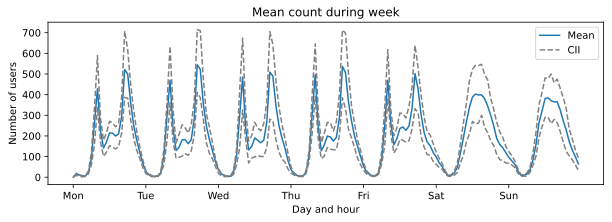

In [49]:
fig, ax = plt.subplots(figsize=(10, 3))

mean_day_hour = df.groupby(["weekday", "hour"])["count"].mean()
q25_dia_hora = df.groupby(["weekday", "hour"])["count"].quantile(0.25)
q75_dia_hora = df.groupby(["weekday", "hour"])["count"].quantile(0.75)

mean_day_hour.plot(ax=ax, label='Mean')
q25_dia_hora.plot(ax=ax, linestyle='dashed', color='gray', label='')
q75_dia_hora.plot(ax=ax, linestyle='dashed', color='gray', label='CII')

ax.set(title="Mean count during week",
       xticks=[i * 24 for i in range(7)],
       xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
       xlabel="Day and hour",
       ylabel="Number of users"
      )

ax.legend();

In [50]:
df['season'] = df['season'].astype('category')
df['weather'] = df['weather'].astype('category')
df['month']   = df['month'].astype('category')
df['weekday'] = df['weekday'].astype('category')
df = pd.get_dummies(df, columns=['season', 'weather', 'month', 'weekday'])

df['hour_sin'] = np.sin(df['hour'] / 23 * 2 * np.pi)
df['hour_cos'] = np.cos(df['hour'] / 23 * 2 * np.pi)
df = df.drop(columns='hour')

In [51]:
train_df = df[:int(len(df) * 0.66)]
test_df = df[int(len(df) * 0.66):]
# test_df['count'] = 0

In [52]:
exog_variables = df.drop(columns=['count']).columns.tolist()

In [53]:
forecaster = ForecasterAutoreg(regressor = CatBoostRegressor(random_state=123, silent=True),
                               lags = 24
                              )

In [54]:
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10],
              'learning_rate': [0.01, 0.1]
             }

lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(forecaster=forecaster,
                                      y=df['count'],
                                      exog=df[exog_variables],
                                      param_grid=param_grid,
                                      lags_grid=lags_grid,
                                      steps=len(test_df),
                                      refit=False,
                                      metric='mean_squared_error',
                                      initial_train_size=int(len(train_df)),
                                      fixed_train_size=False,
                                      return_best=True,
                                      verbose=False
                                     )

Number of models compared: 24.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [02:18<00:00, 69.03s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 268.1823404250749



In [55]:
metric, predictions = backtesting_forecaster(forecaster=forecaster,
                                             y=df['count'],
                                             initial_train_size=int(len(train_df)),
                                             fixed_train_size=False,
                                             steps=36,
                                             refit=False,
                                             metric='mean_squared_error',
                                             verbose=False
                                            )

predictions

,pred
2012-04-19 12:00:00,233.597282
2012-04-19 13:00:00,222.162665
2012-04-19 14:00:00,177.673585
2012-04-19 15:00:00,173.748499
2012-04-19 16:00:00,296.738352
...,...
2012-12-19 19:00:00,374.640795
2012-12-19 20:00:00,252.164430
2012-12-19 21:00:00,162.893634
2012-12-19 22:00:00,120.646153


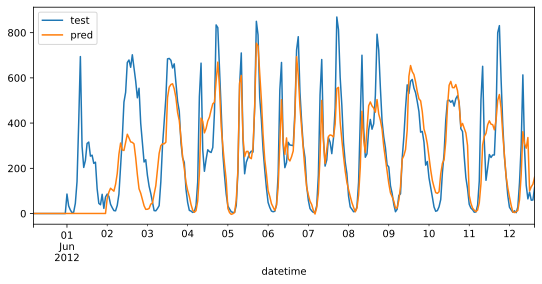

In [65]:
fig, ax=plt.subplots(figsize=(9, 4))

# train_df['count'].plot(ax=ax, label='train')
test_df['count'][1000:1300].plot(ax=ax, label='test')
predictions[1000:1300].plot(ax=ax, label='predictions')

ax.legend();